# Slicing volume, smoothing & subsampling


Model preparation for Specfem's input using precomputed cubes. Only for rectangular area. To include rotation, check folder (Notebooks)

In [1]:
#load all necessary module
from sys import argv
from sys import path
import numpy as np
import pandas as pd
import scipy as sp
from scipy import ndimage
from scipy import signal
import matplotlib.pyplot as plt 
from matplotlib.colors import Normalize
from scipy.interpolate import RegularGridInterpolator
from gnam.model.gridmod3d import gridmod3d as gm
from gnam.model.bbox import bbox as bb


In [15]:
#SET PATH TO MODULE
path.append("/ribarsko/home/masfara/GNAM_IBAN/")

In [2]:
#load data pregenerated data (for details see notebooks folder)
ifilename = '../../PYTHON/TESMOD/gnam/notebooks/z10m_nam_model_vp_vs_rho_Q_props_Iban.npz'

#unpickle the data above
data = np.load(ifilename)
props = data['props'] #4D ndarray

#meta data arrays
xdata = data['xd'] 
ydata = data['yd']
zdata = data['zd']

print('xd:\n',xdata)
print('yd:\n',ydata)
print('zd:\n',zdata)

# Setup Coordinate related vars
xmin = xdata[0]
dx   = xdata[1]
nx   = int(xdata[2])
xmax = xmin + (nx-1)*dx

ymin = ydata[0]
dy   = ydata[1]
ny   = int(ydata[2])
ymax = ymin + (ny-1)*dy

zmin = zdata[0]
dz   = zdata[1]
nz   = int(zdata[2])
zmax = (-zmin) + (nz-1)*dz

xd:
 [2.074625e+05 5.000000e+01 1.450000e+03]
yd:
 [5.559625e+05 5.000000e+01 1.198000e+03]
zd:
 [  0.  10. 401.]


In [3]:
#take all fields and put to gm 
nsub_props = props.shape[0]
axes_order = {'X':0,'Y':1,'Z':2} #this dict keeps track of axes order
gm3d = gm(props,nsub_props,axes_order,(nx,ny,nz),(dx,dy,dz),(xmin,ymin,zmin))
print(gm3d)

{'ncells': (1449, 1197, 400), 'npoints': (1450, 1198, 401), 'deltas': (50.0, 50.0, 10.0), 'origin': (207462.5, 555962.5, 0.0), 'rotation (degres)': 0, 'rotation (rads)': 0.0, 'shape': (4, 1450, 1198, 401), 'Axis Order': {'X': 0, 'Y': 1, 'Z': 2}}


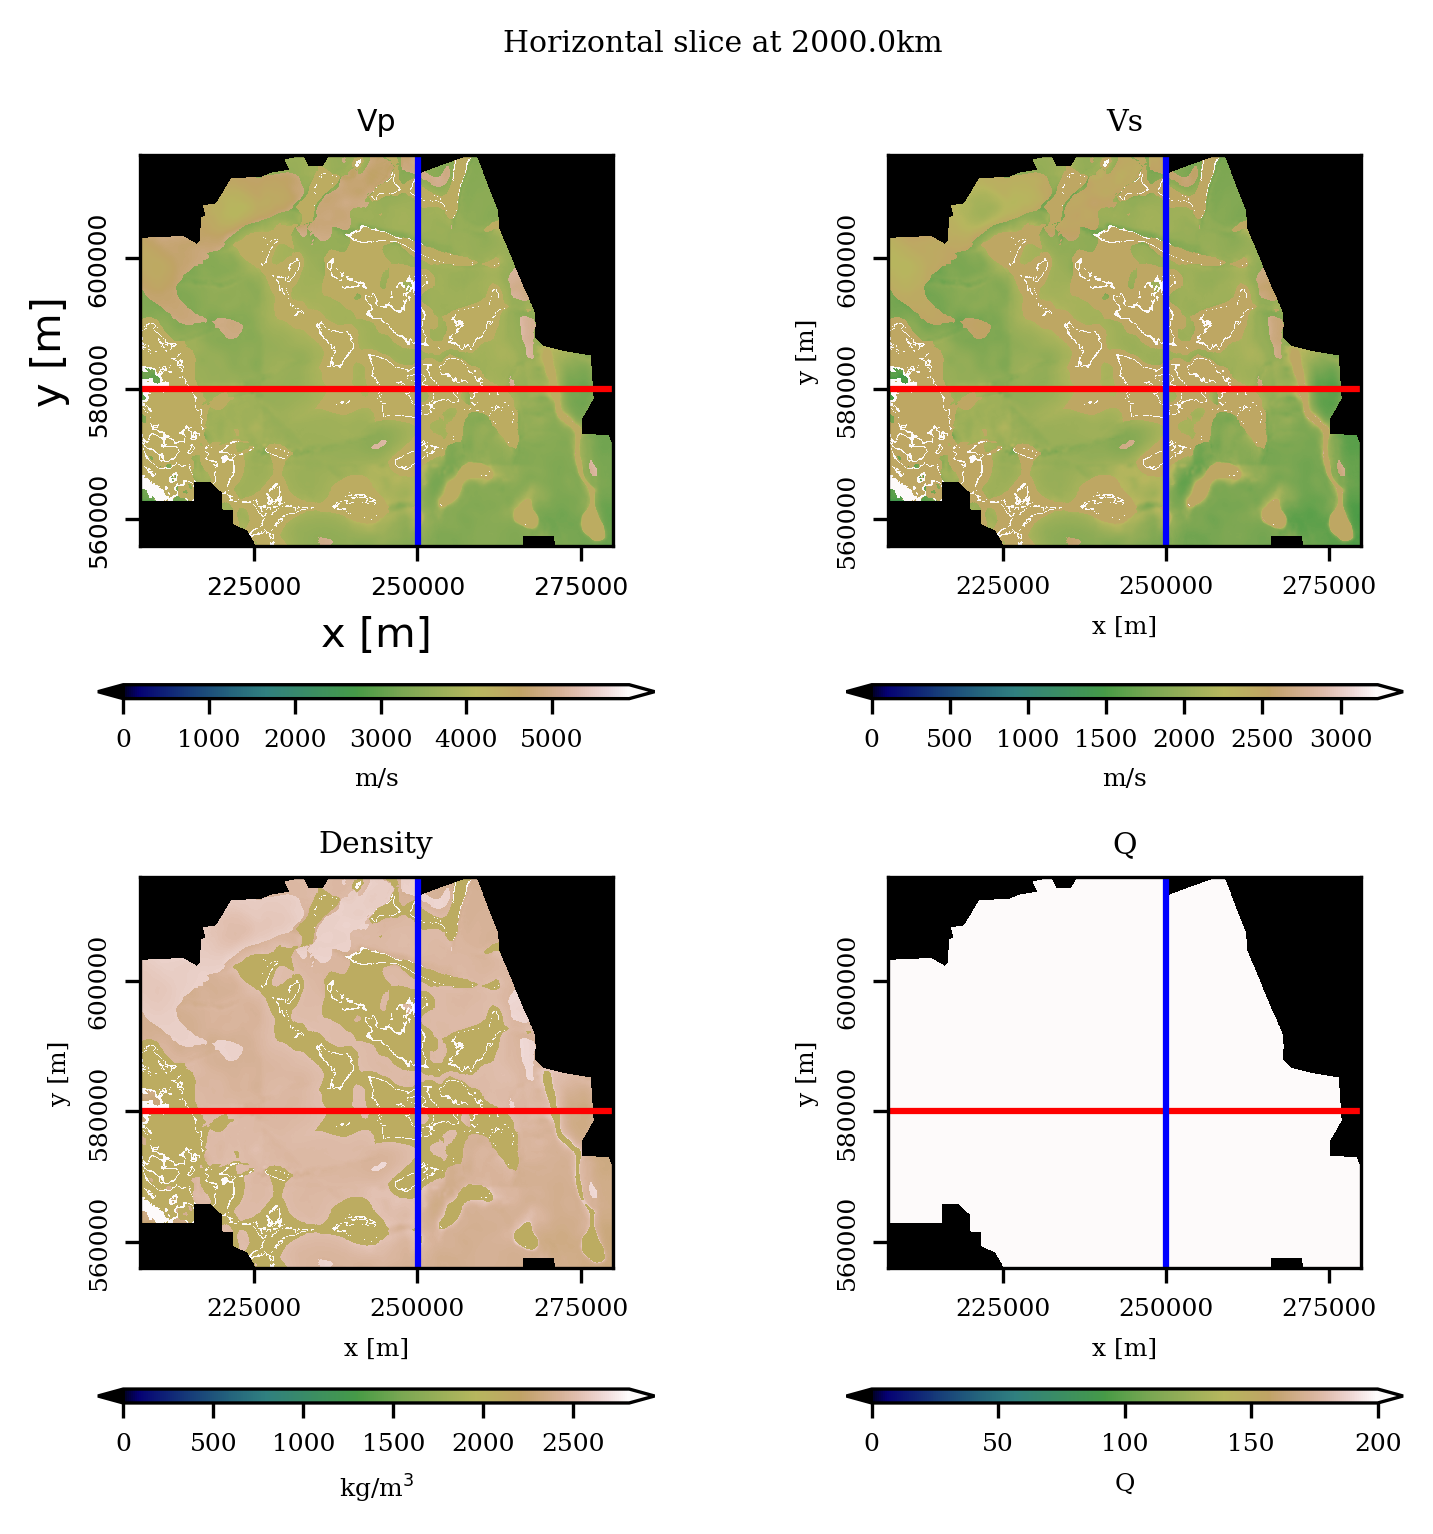

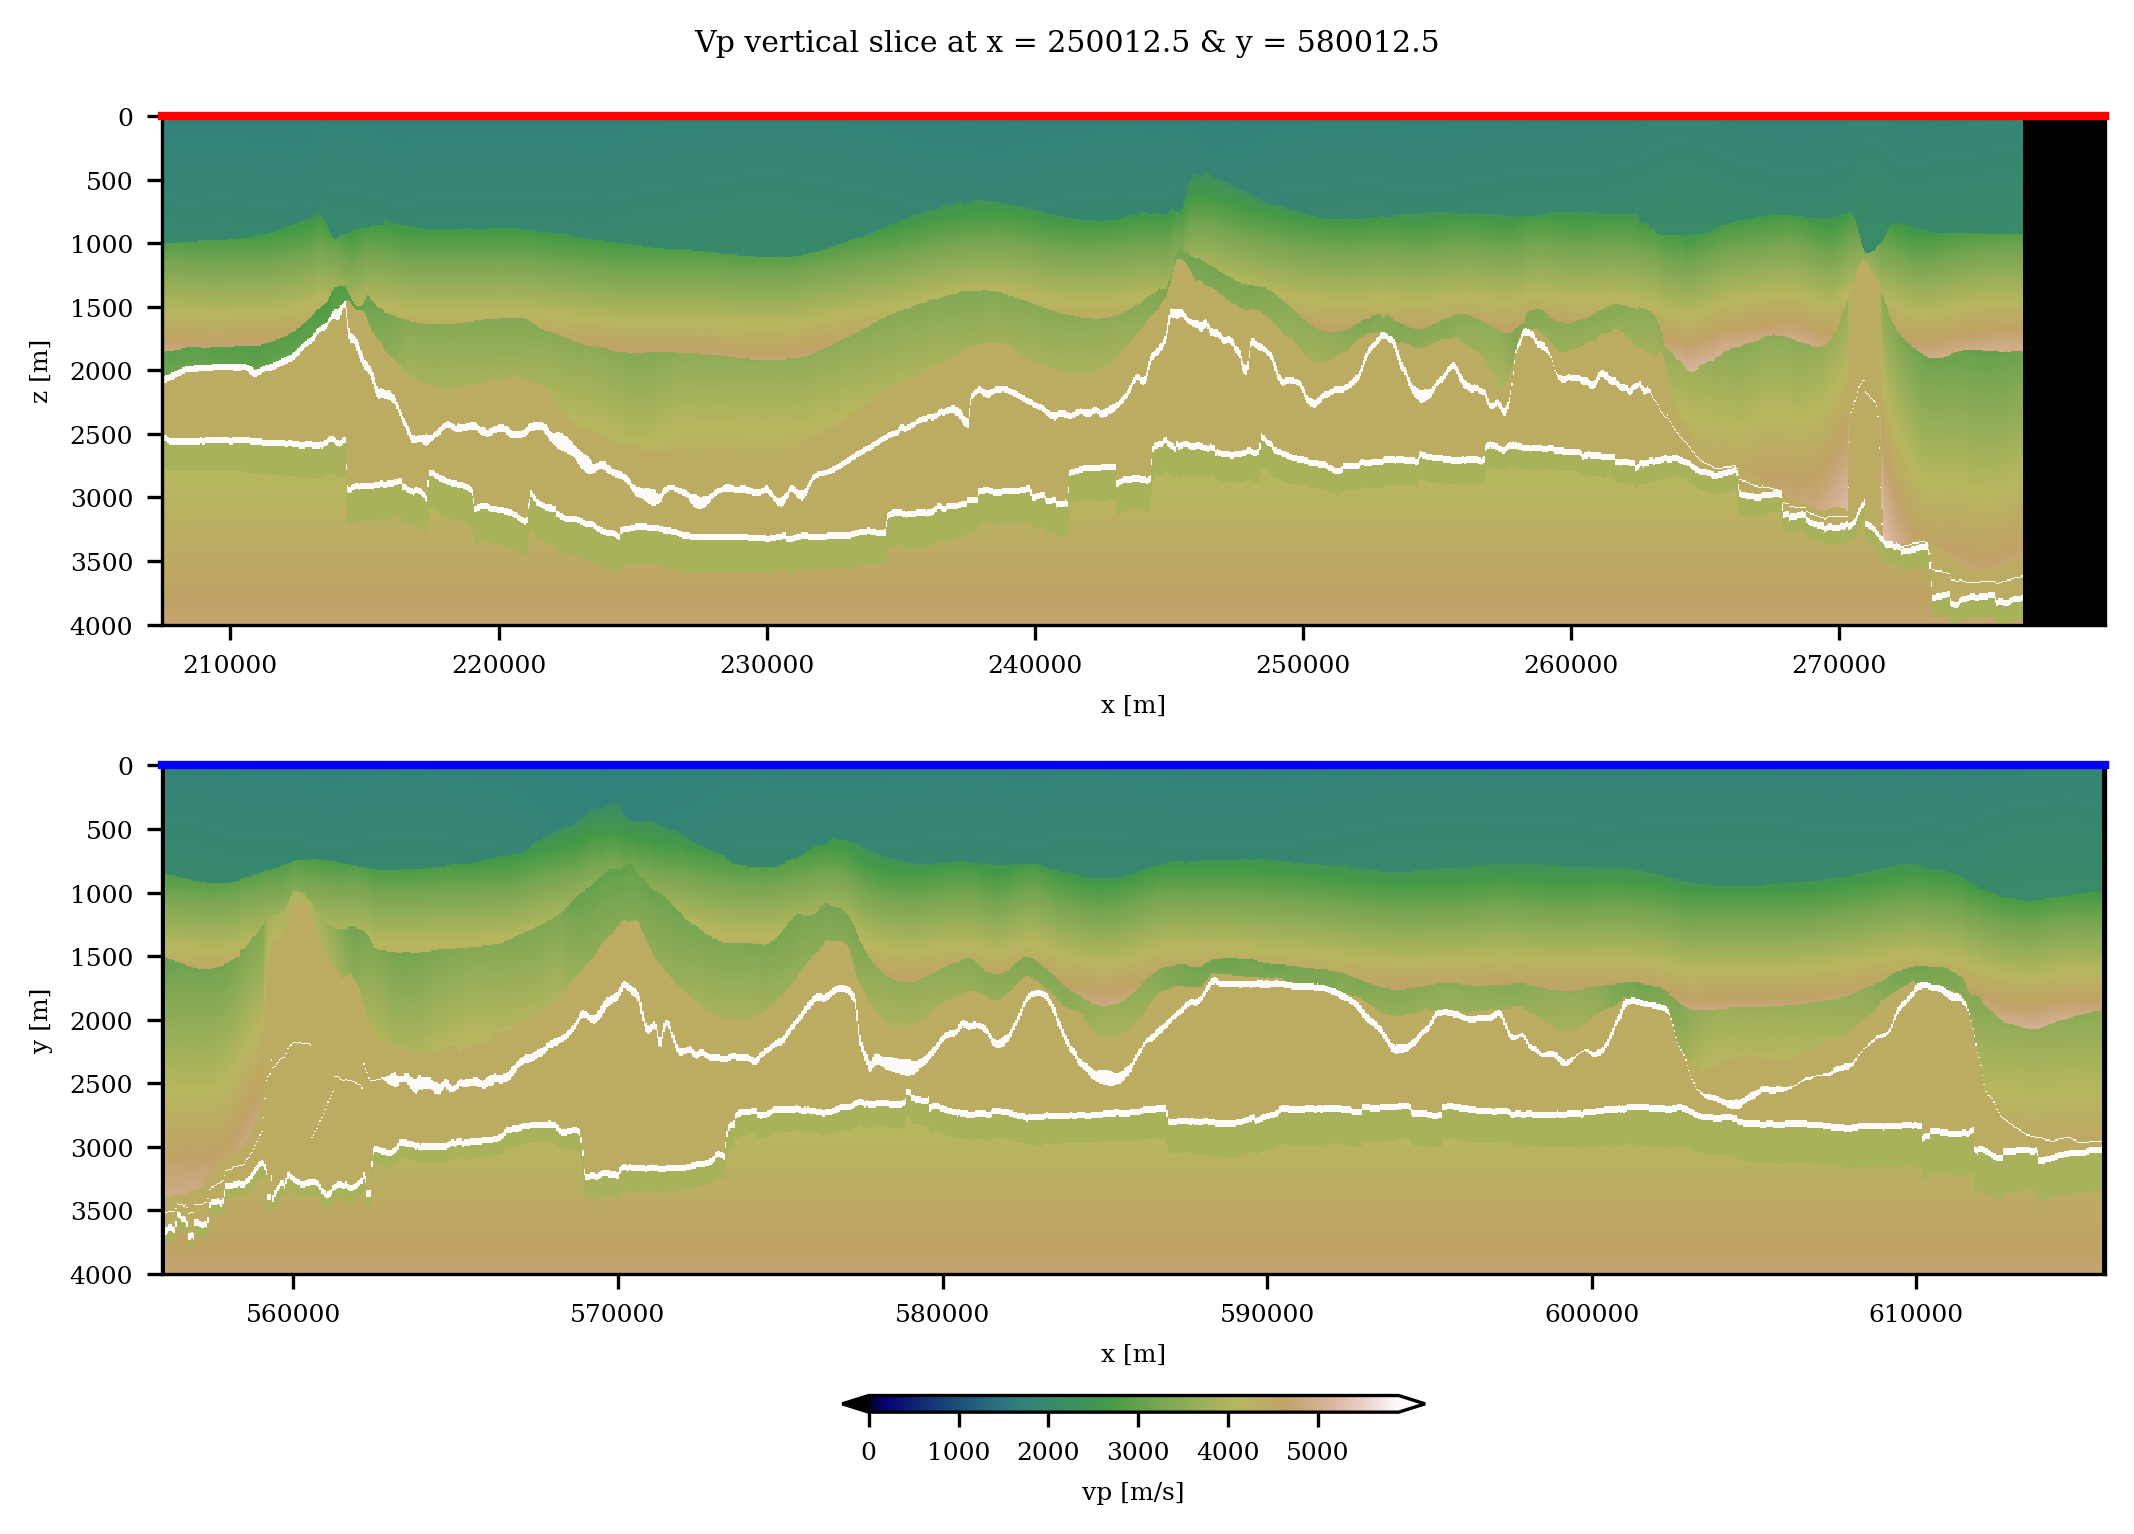

In [4]:
#QC the volume and plot the slice 
gm3d.QCvolume(xslice=250000,yslice=580000,zslice=2000)

In [5]:
print(gm3d)

{'ncells': (1449, 1197, 400), 'npoints': (1450, 1198, 401), 'deltas': (50.0, 50.0, 10.0), 'origin': (207462.5, 555962.5, 0.0), 'rotation (degres)': 0, 'rotation (rads)': 0.0, 'shape': (4, 1450, 1198, 401), 'Axis Order': {'X': 0, 'Y': 1, 'Z': 2}}


## Slicing volume based on rectangle

In [6]:
#create rectangle for volume slice 
#x1,x2,y1,y2
bound = (226000,250000,580000,600000)


slicing volume


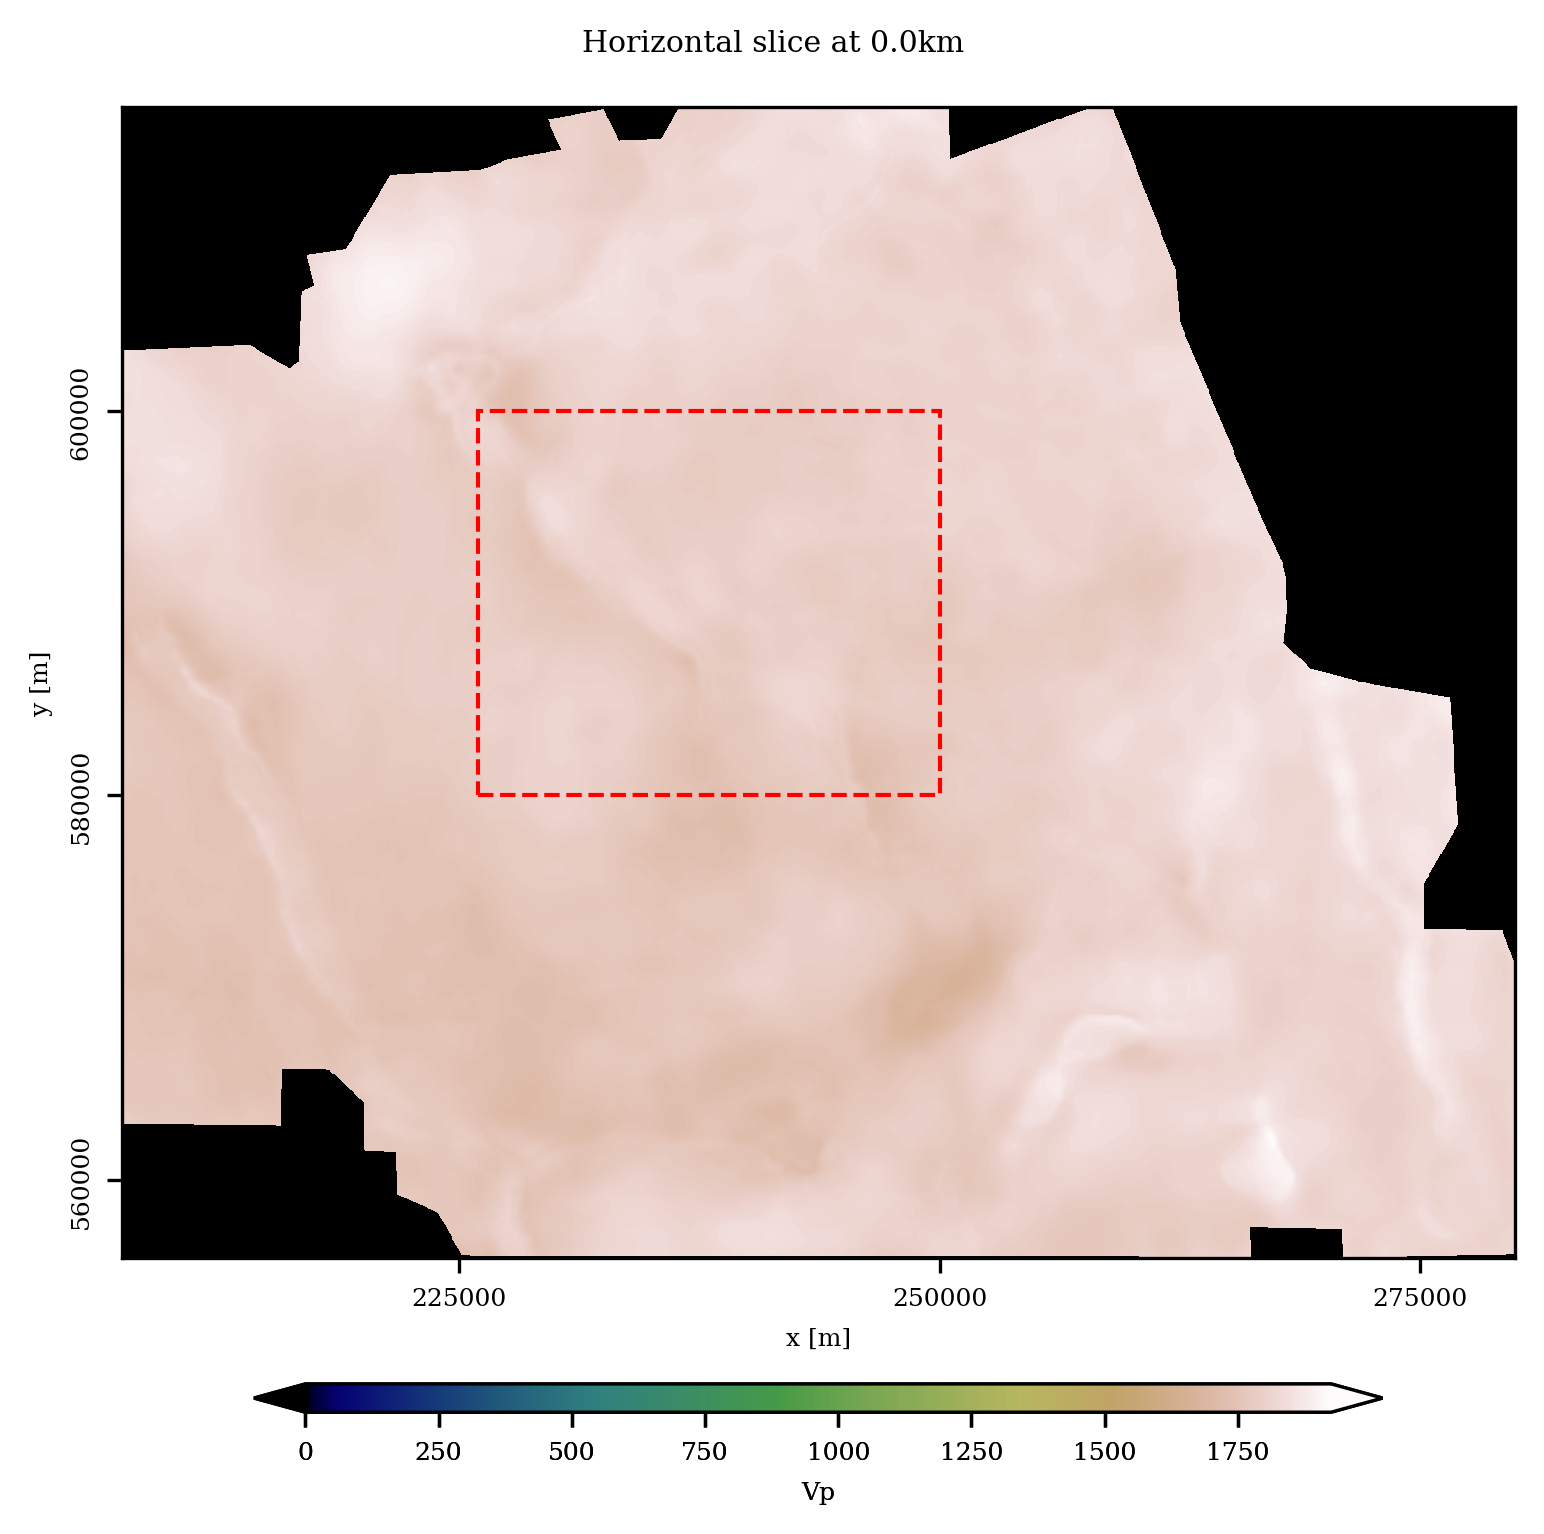

In [7]:
#Slice volume
#turn slicenow to false for just QC the rectangle
slgm3d = gm3d.QCslicerectangular(boundingbox=bound,zslice = 0,slicenow=True)

#delete gm3d
del gm3d

## Smoothing sliced volume

In [8]:
#get the lenght of smoothing kernel
sigma = slgm3d.get_sigma(100)

sigma nx,ny,nz --> 2 2 10
sigma in m dx,dy,dz --> 100.0 100.0 100.0


In [9]:
#smoothing
slgm3d.smoothXYZ(sigma[0],sigma[1],sigma[2])

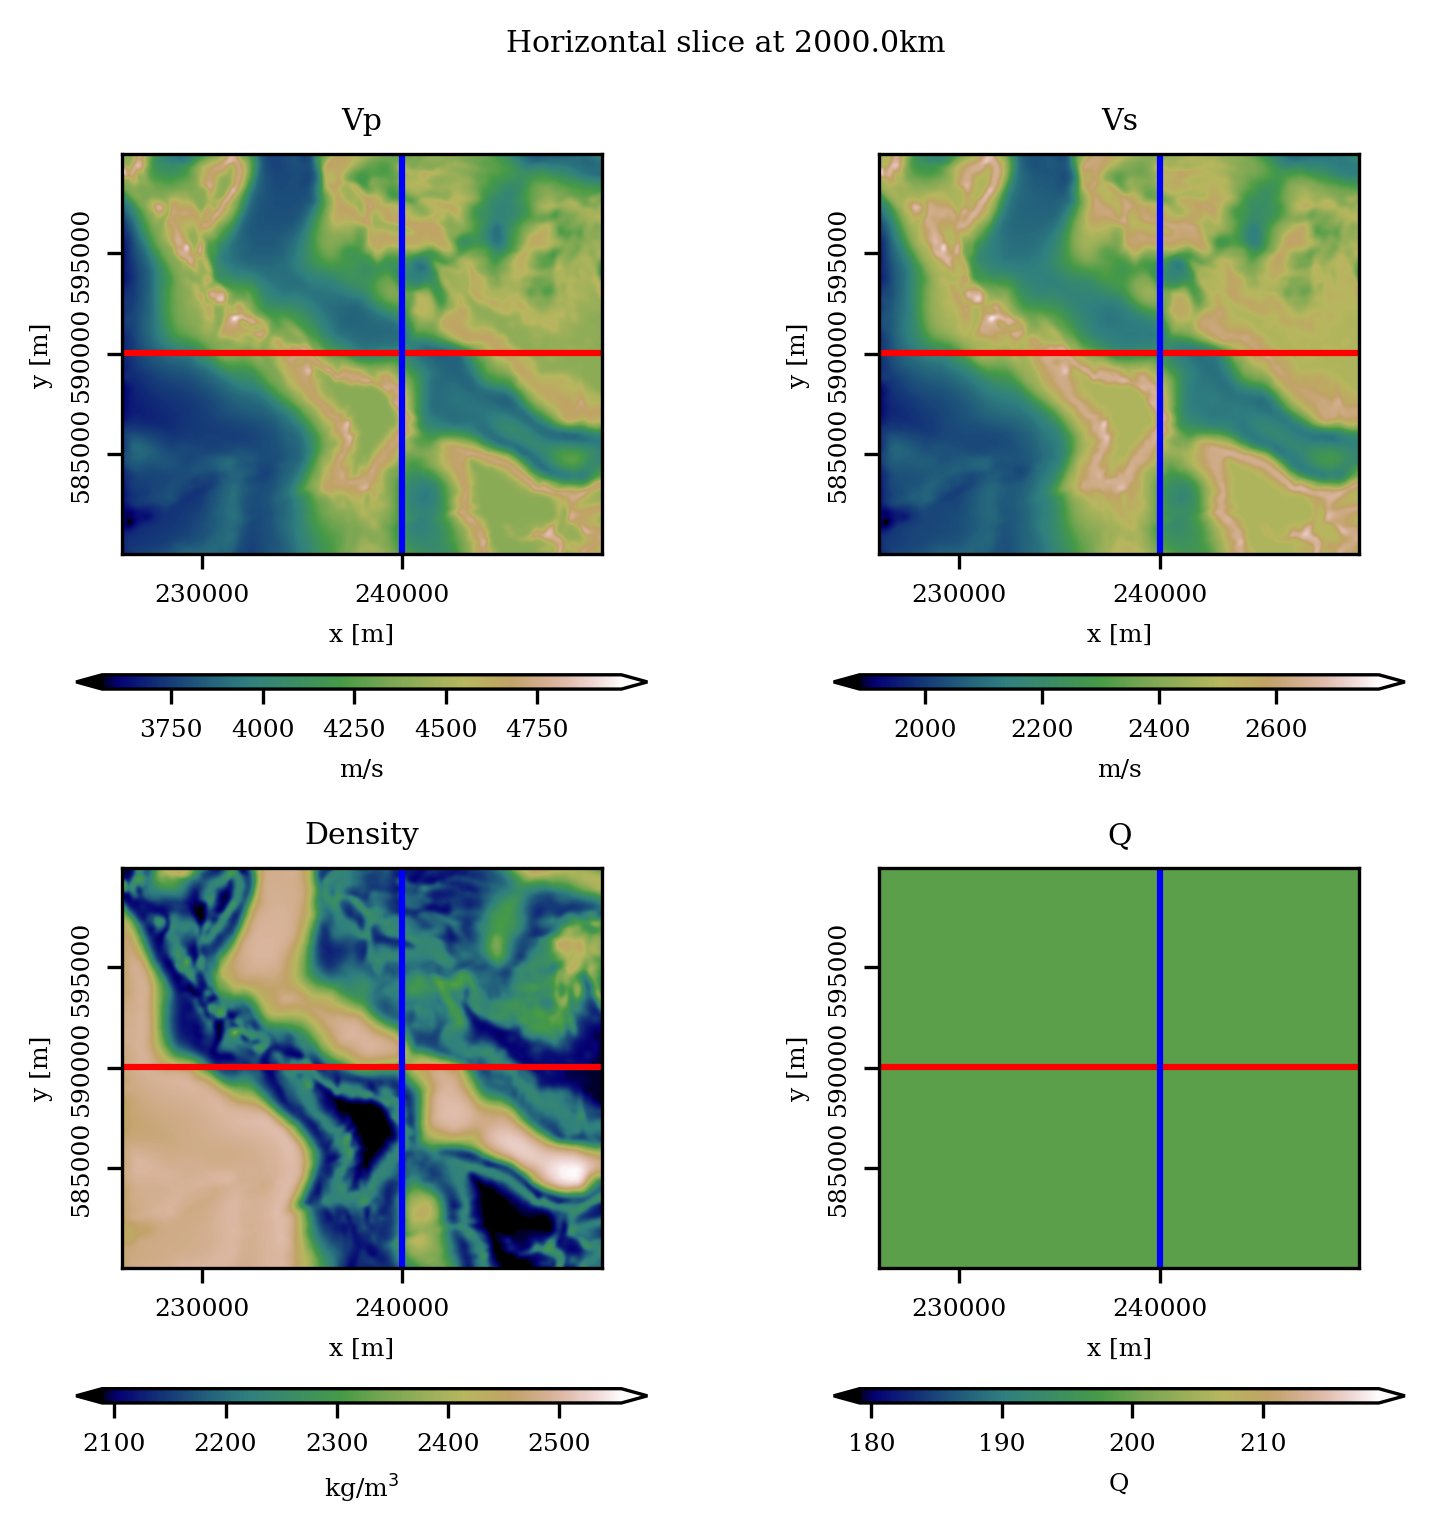

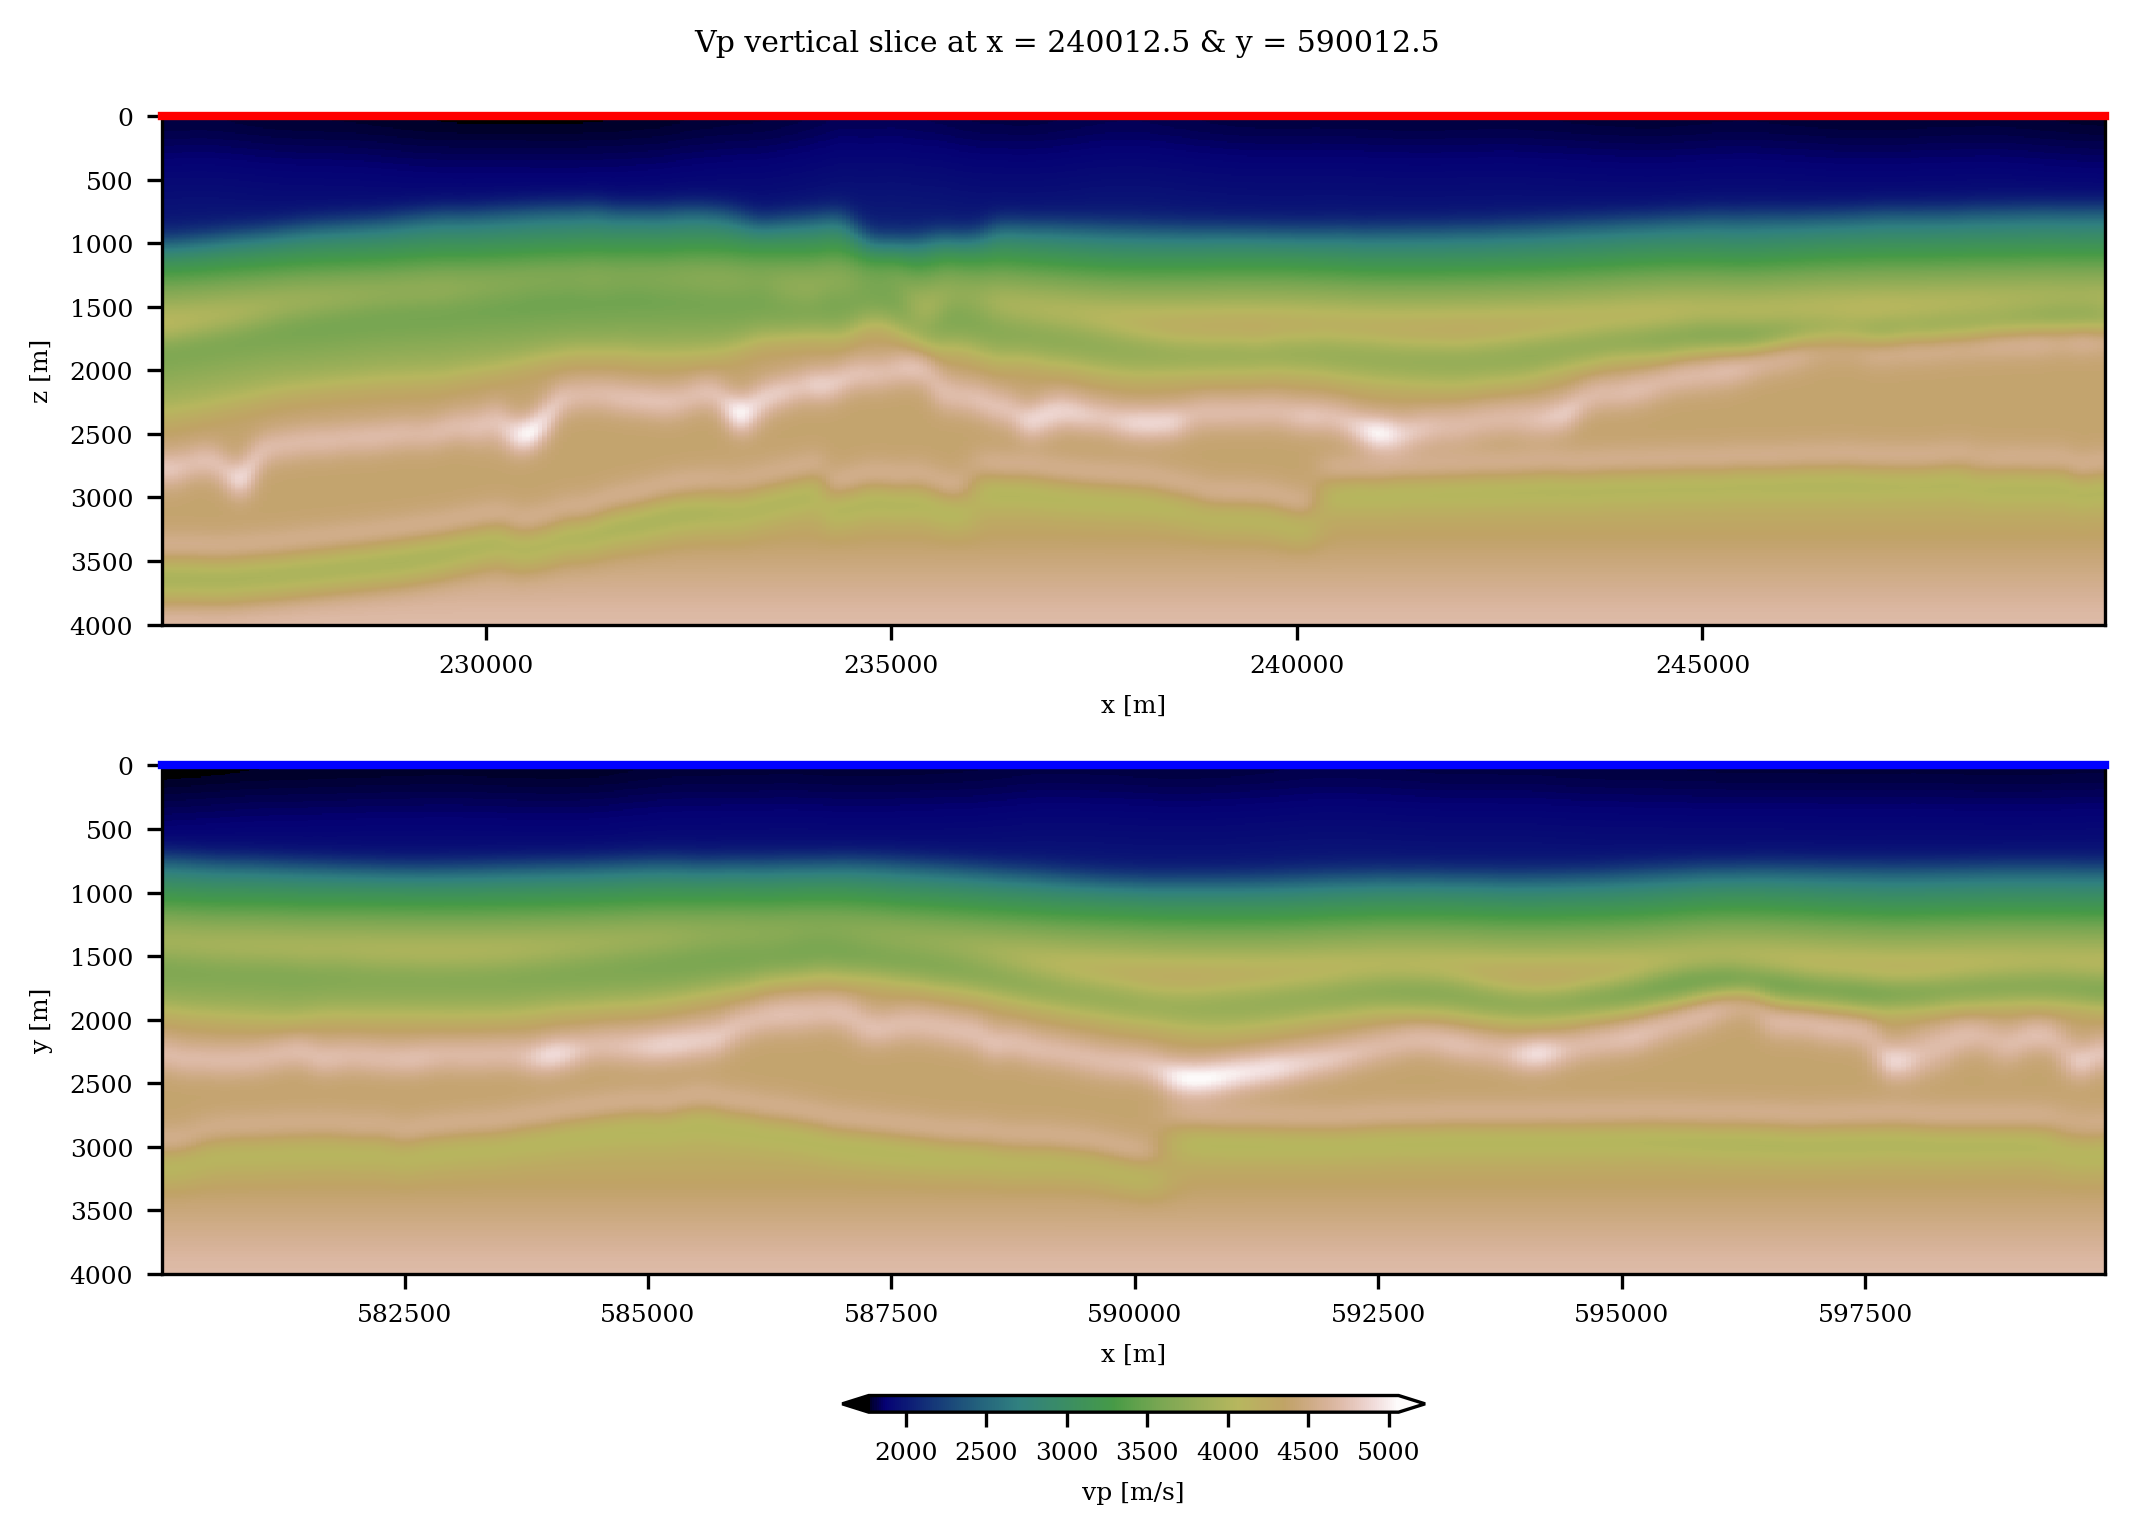

In [10]:
#QC the result
slgm3d.QCvolume(xslice=240000,yslice=590000,zslice=2000)

## Subsampling sliced volume

In [11]:
#prepare spacing for subsampling
newdelta = slgm3d.get_deltasubsamp(100)

old dx,dy,dz [m] --> 50.0 50.0 10.0
new dx,dy,dz [m] --> 100


In [12]:
#subsampling
#isz must half delta z 
slgm3d.subsample(isz=newdelta[2]/2,idx=newdelta[0],idy=newdelta[1],idz=newdelta[2]) 

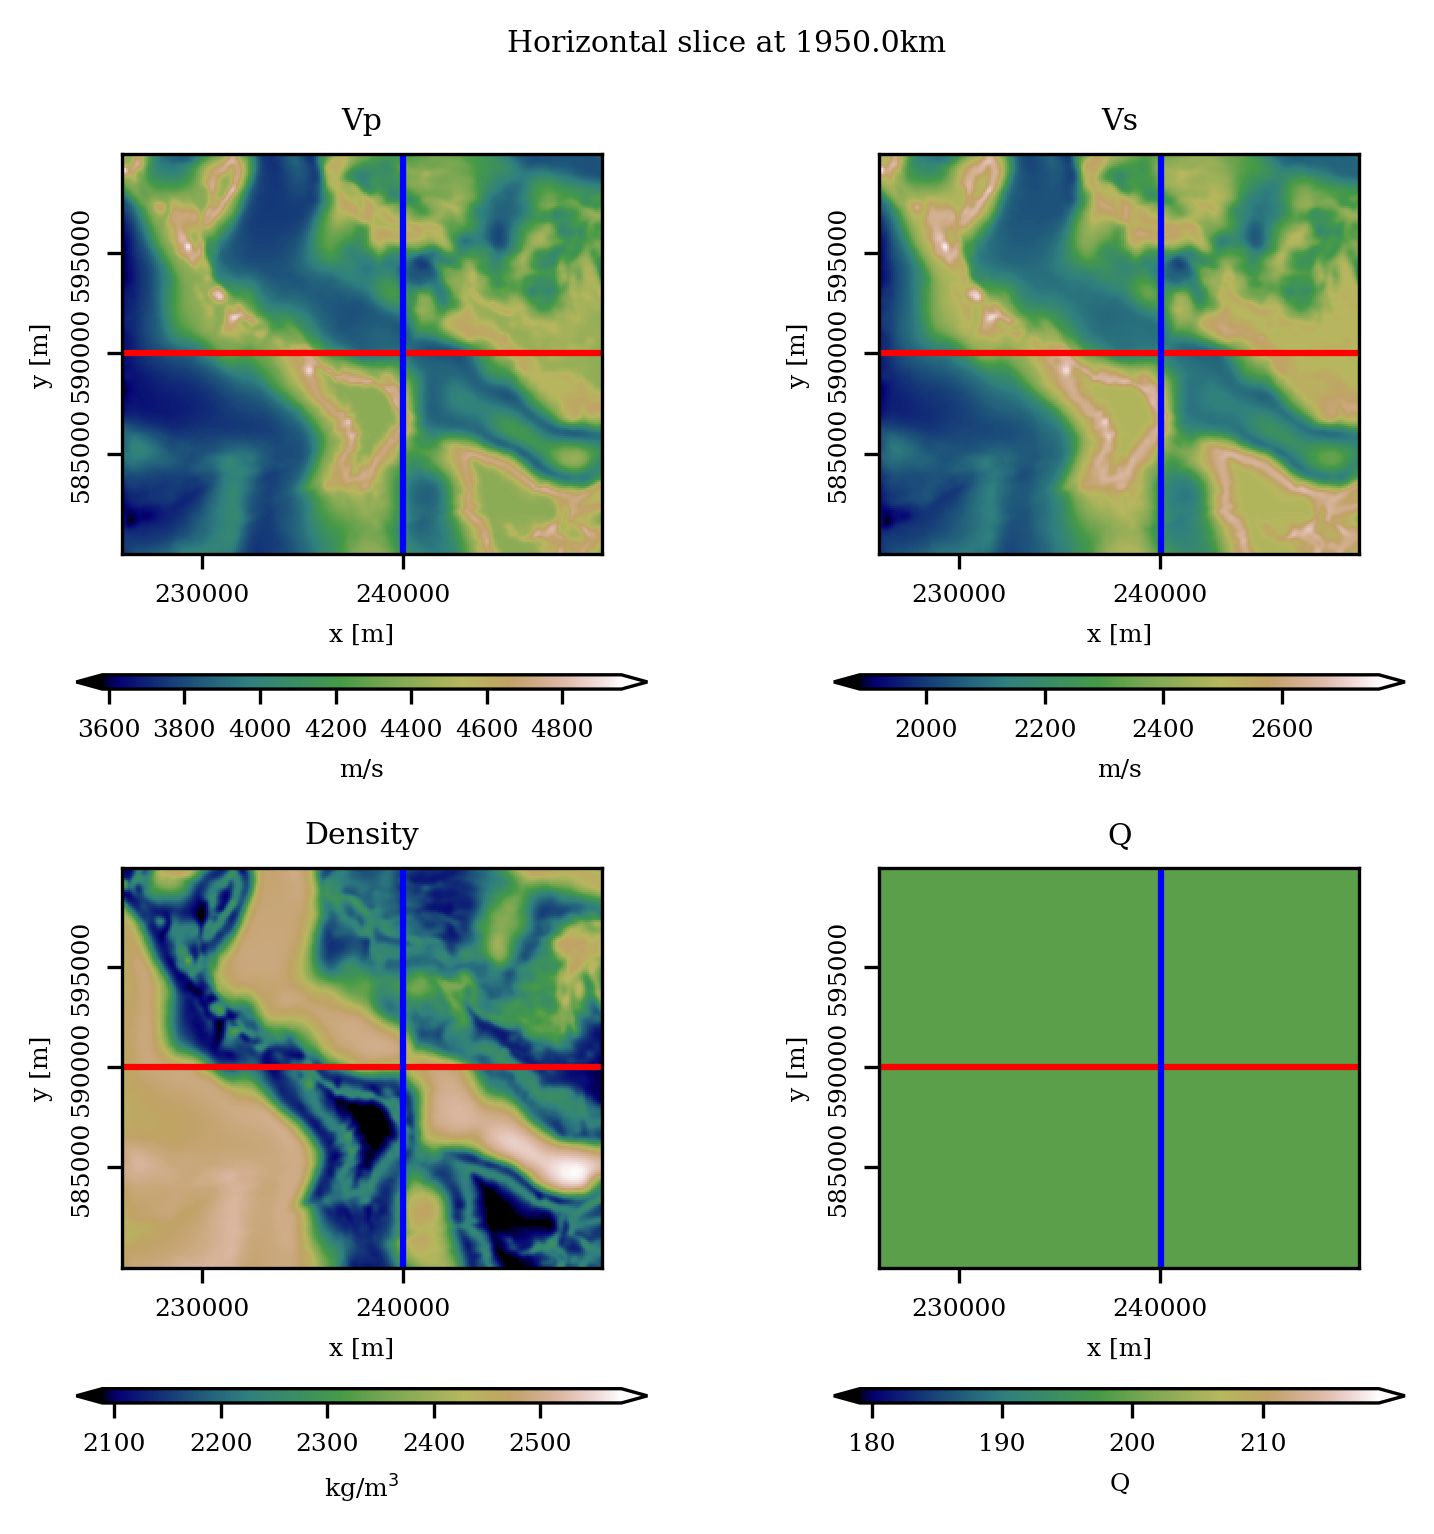

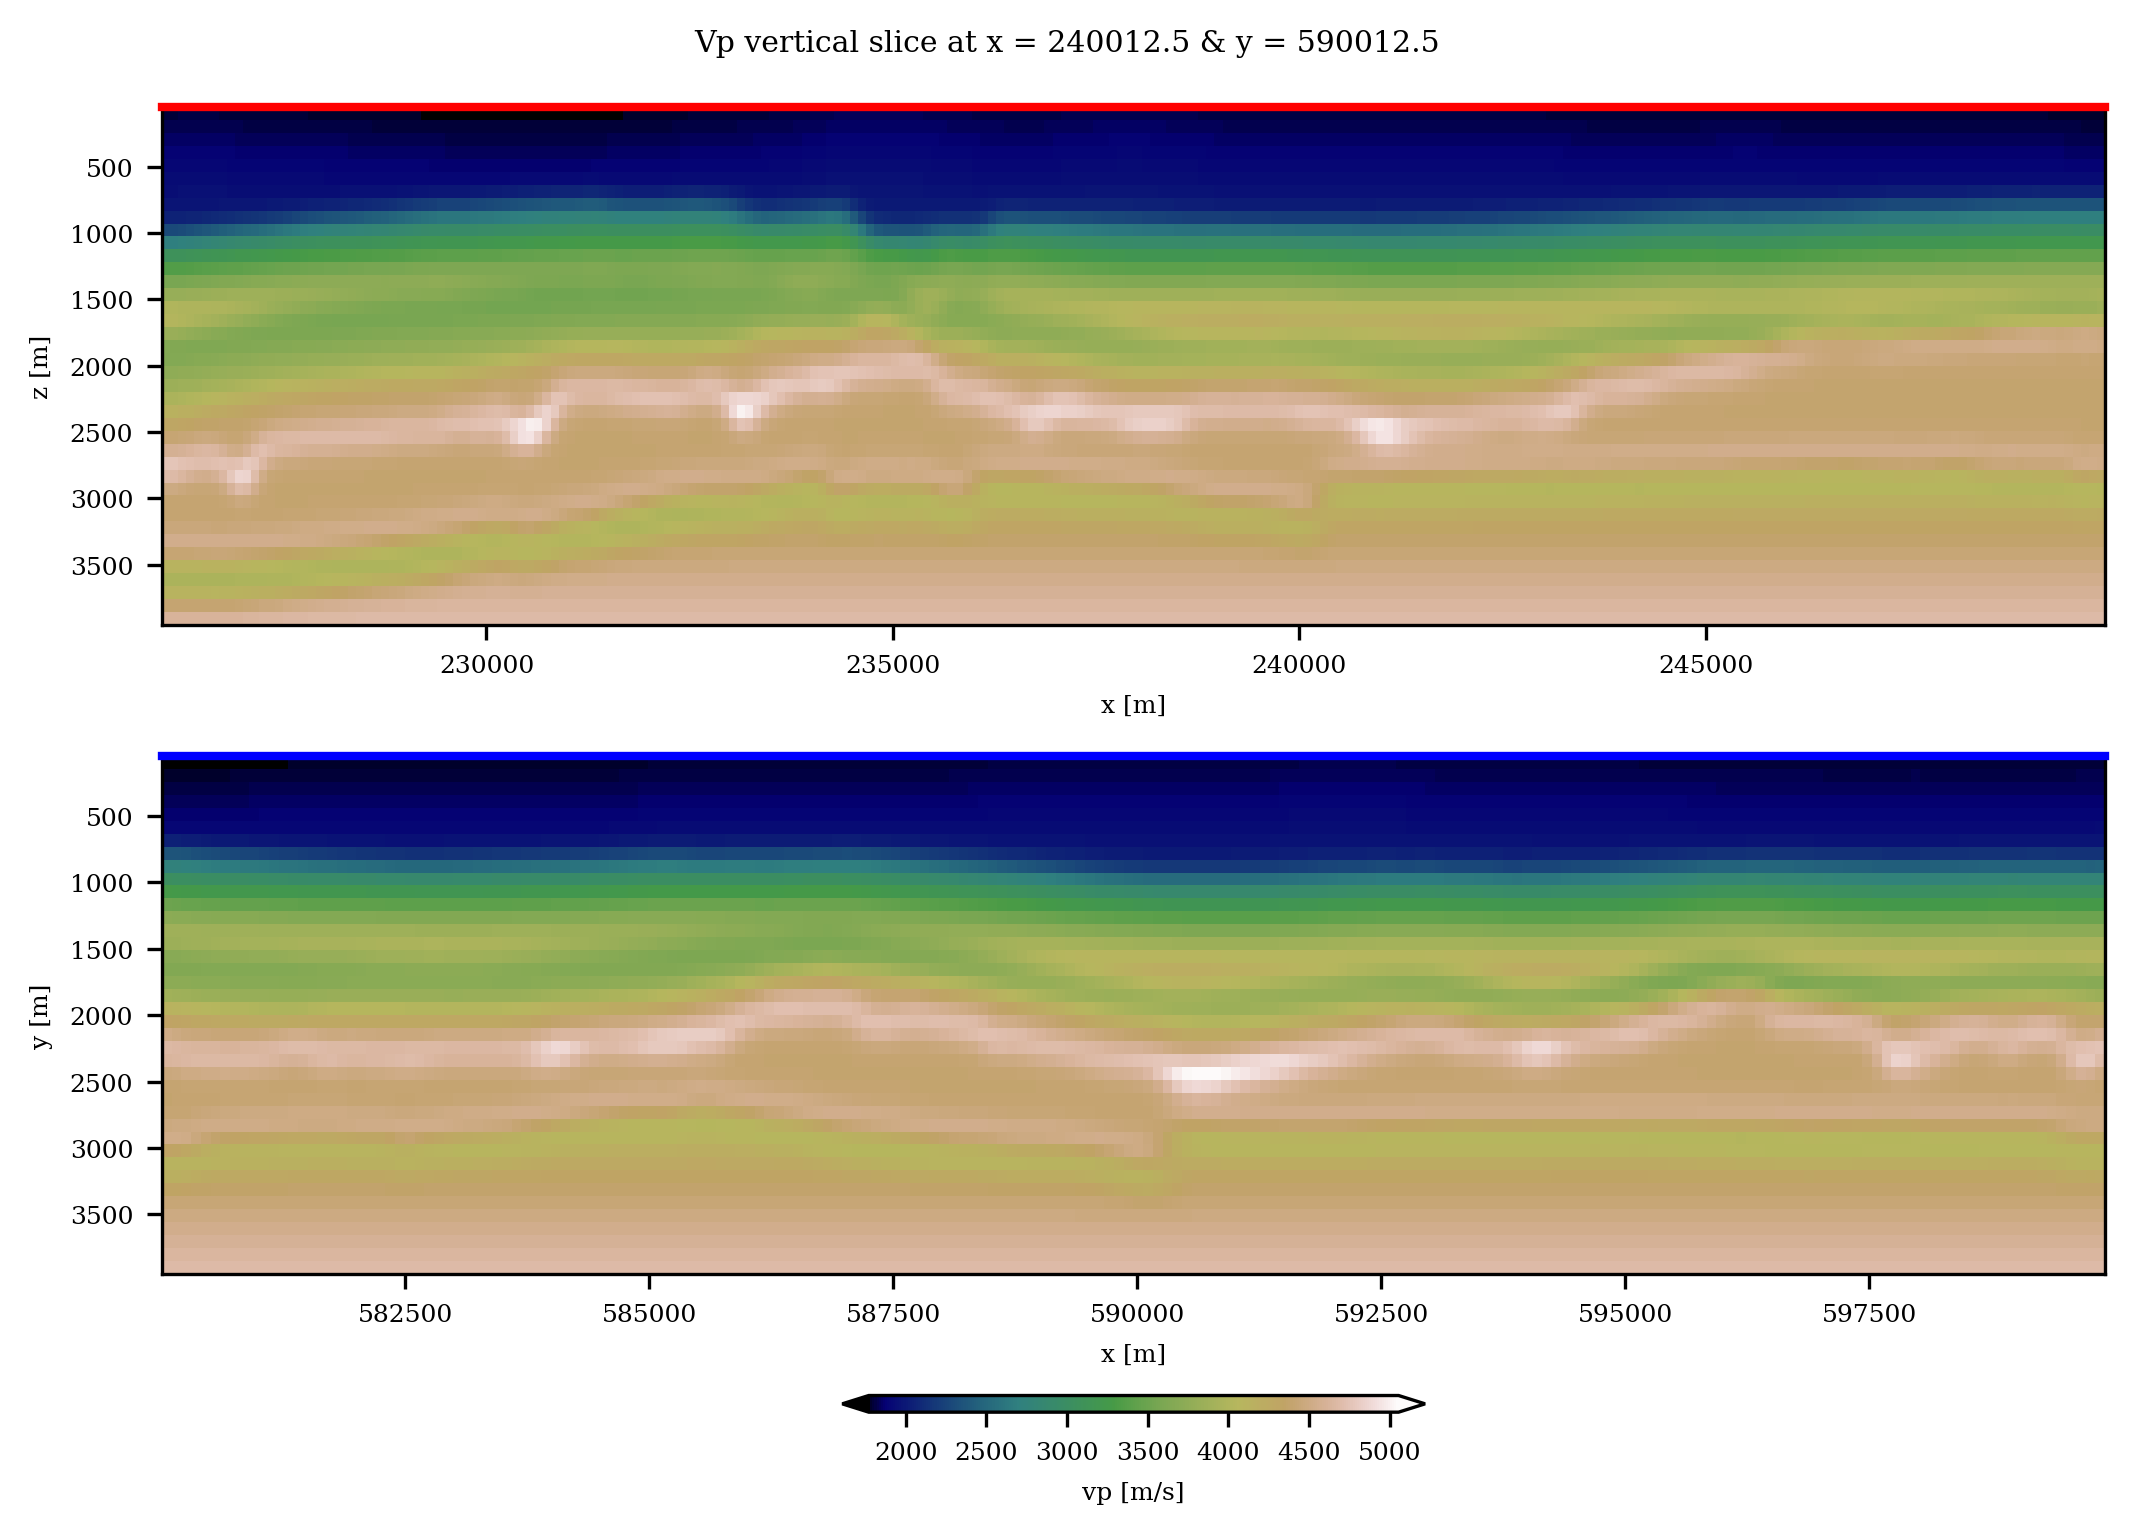

In [13]:
#QC the result
slgm3d.QCvolume(xslice=240000,yslice=590000,zslice=2000)

# Writing for SPECFEM MESH

In [14]:
#write the mesh
from gnam.specutils.gmutil import gmutil

gmu = gmutil()
gmu.writeSpecfem3DMesh('./MESH-test_iban4', slgm3d)